Escriba el nombre del archivo:
Tokyo
Convirtiendo...
Listo.


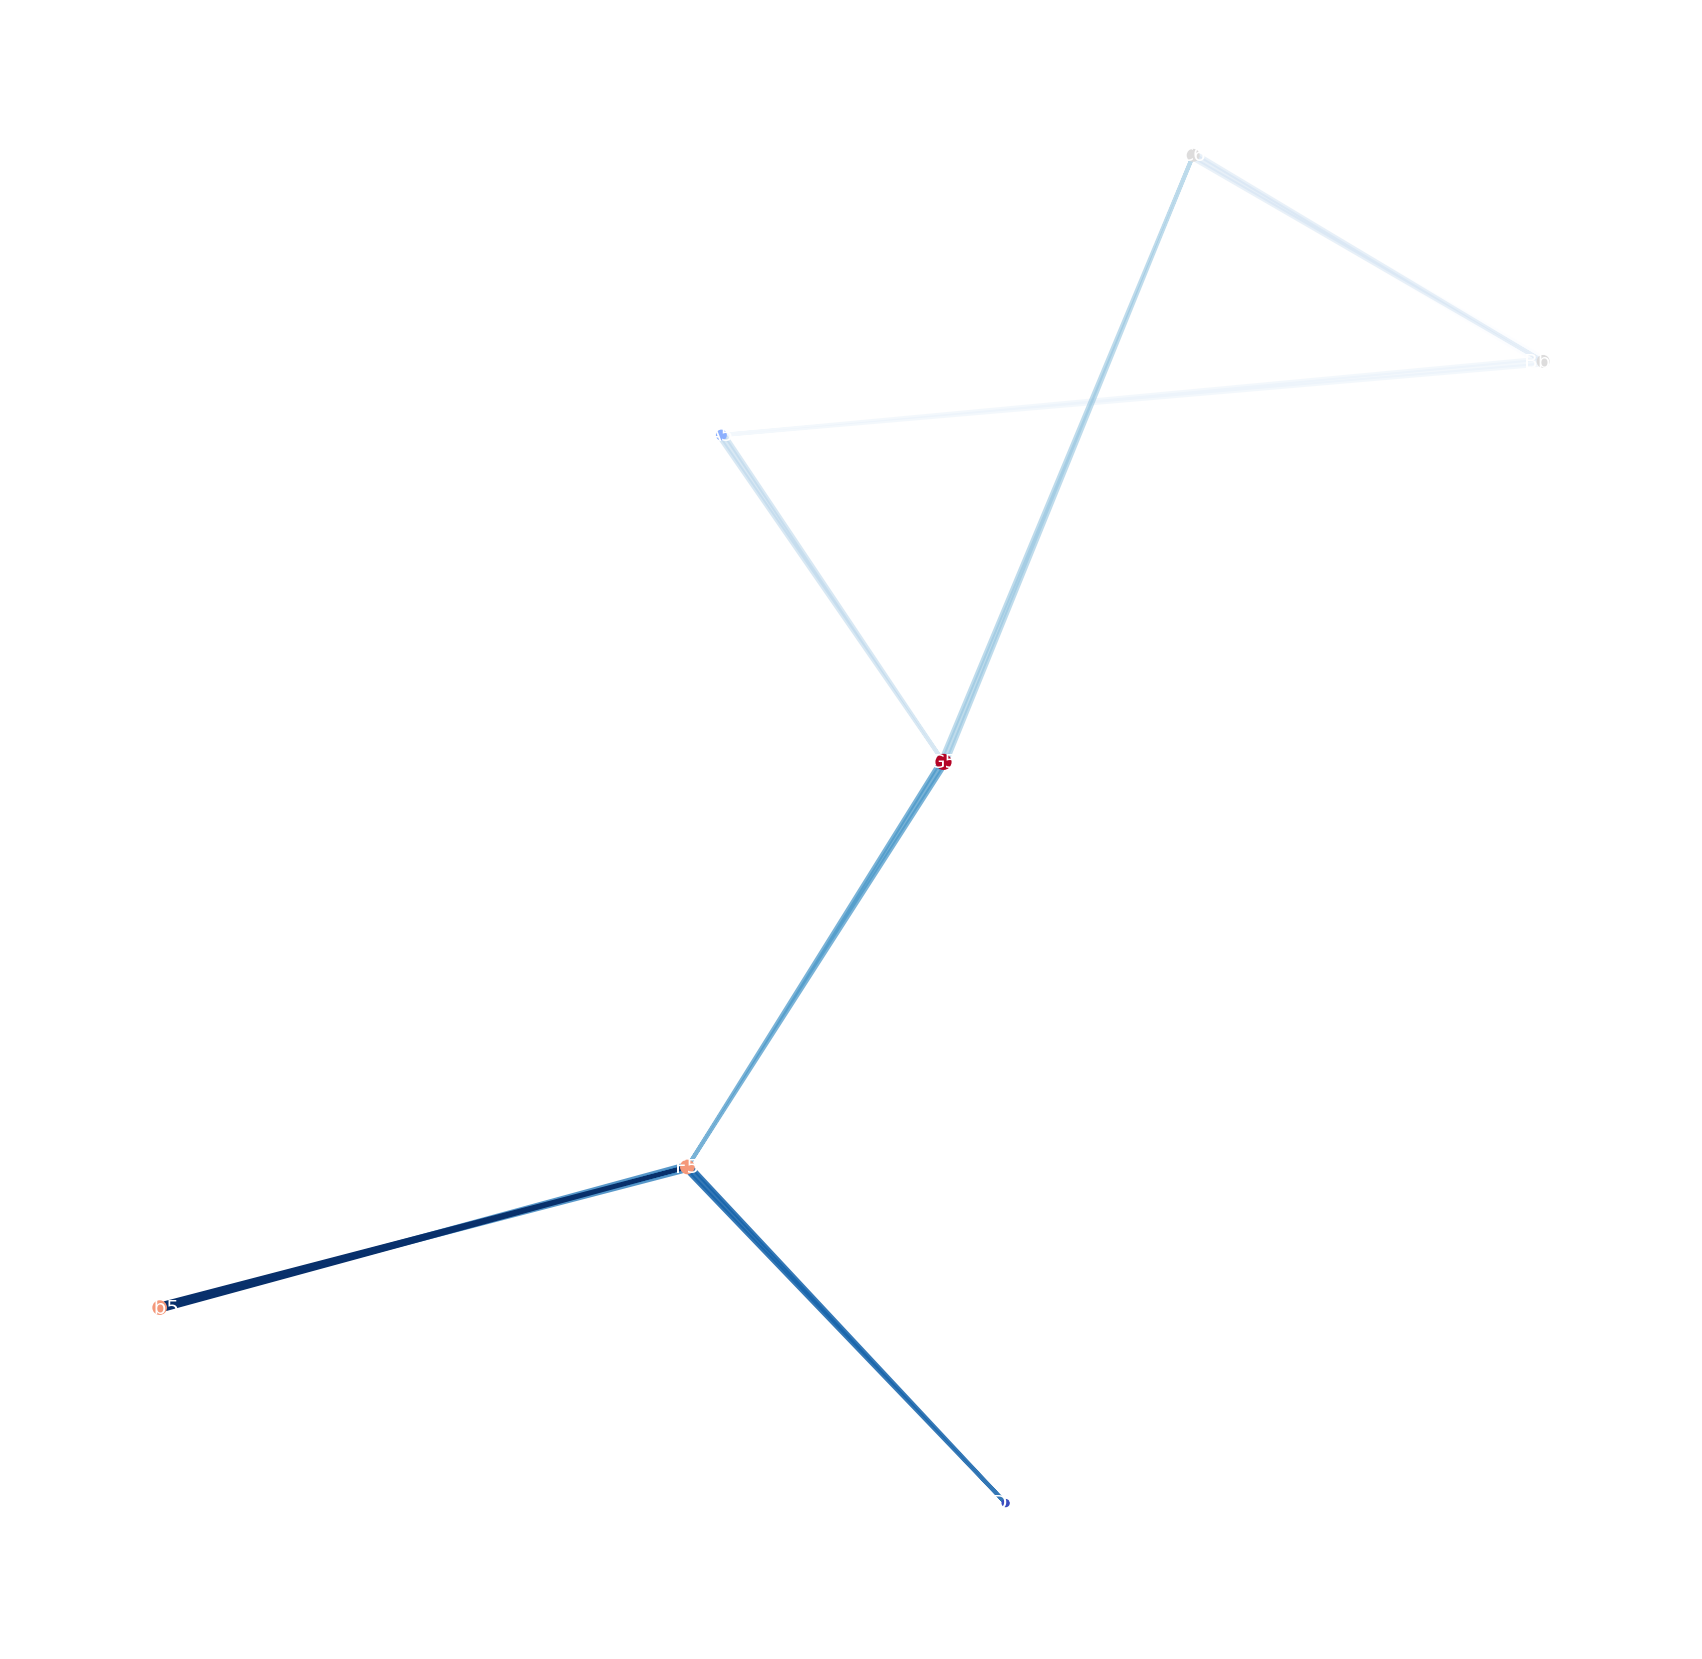

Pasando grafo a formato tridimensional...
Listo.


In [50]:
import igraph as ig
import netgraph
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import music21 as m
import os
import chart_studio.plotly as py
import plotly.graph_objs as go


aDir = os.getcwd()
nombre = input("Escriba el nombre del archivo:\n")
song = m.converter.parse('{0}/ArchiXml/{1}.xml'.format(aDir, nombre))
print("Convirtiendo...")
#sp = m.midi.realtime.StreamPlayer(song)
# sp.play()
# process the ties
#song = song.stripTies()
song = song.stripTies()

# unfold repetitions
i = 0
for a in song:
    if a.isStream:
        e = m.repeat.Expander(a)
        s2 = e.process()
        timing = s2.secondsMap
        song[i] = s2
    i += 1

# todo: add note onsets


def getMusicProperties(x):
    s = ''
    t = ''
    r = ''
    s = str(x.pitch)

    if x.tie != None:
        t = 't'
    elif(x.isRest):
        r = x.duration+'r'
    s += t+r
    s=s.replace('-','b')
    return s


notas = []
for a in song.recurse().notes:

    if (a.isNote):
        x = a
        s = getMusicProperties(x)
        notas.append(s)

    if (a.isChord):
        n = ''
        for x in a._notes:
            s = getMusicProperties(x)
            n += ' '+s
        notas.append(n[1:])

    if (a.isRest):
        print("hola")
        x = a
        s = getMusicProperties(x)
        notas.append(s)

n = notas
G = nx.DiGraph()
for i in range(len(n)):
    if i != 0:
        G.add_edge(n[i-1], n[i])

pos = nx.layout.kamada_kawai_layout(G)

d = dict(G.degree)
low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
node_sizes = [v*10 for v in d.values()]
M = G.number_of_edges()
edge_colors = range(2, M+2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
fig = plt.figure()
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[mapper.to_rgba(i) for i in d.values()]
)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="wedge",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
labels = nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_color="white",
)
# set alpha value for each edge
colorFE = []
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])
    colorFE.append(edge_alphas[i])

# pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
# pc.set_array(edge_colors)
# plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
fig.set_facecolor("#9e999800")
fig.set_size_inches((15, 15))
print("Listo.")
plt.show()

print("Pasando grafo a formato tridimensional...")
Nodes = list(G.nodes)
edges2 = list(G.edges)
N = len(Nodes)
Edges = []
for i in edges2:
    i = list(i)
    for j in range(2):
        i[j] = Nodes.index(i[j])
    i = tuple(i)
    Edges.append(i)

Grafo = ig.Graph(Edges, directed=True)

layt = Grafo.layout('kk', dim=3)

Xn = [layt[k][0] for k in range(N)]  # x-coordinates of nodes
Yn = [layt[k][1] for k in range(N)]  # y-coordinates
Zn = [layt[k][2] for k in range(N)]  # z-coordinates
Xe = []
Ye = []
Ze = []
for e in Edges:
    Xe += [layt[e[0]][0], layt[e[1]][0], None]  # x-coordinates of edge ends
    Ye += [layt[e[0]][1], layt[e[1]][1], None]
    Ze += [layt[e[0]][2], layt[e[1]][2], None]

trace1 = go.Scatter3d(x=Xe,
                      y=Ye,
                      z=Ze,
                      mode='lines',
                      line=go.scatter3d.Line(
                          color=colorFE,
                          colorscale="Blues",
                          width=3
                      ),
                      hoverinfo='none'
                      )

trace2 = go.Scatter3d(x=Xn,
                      y=Yn,
                      z=Zn,
                      mode='markers',
                      name='notes and chords',
                      marker=dict(symbol='circle',
                                  size=6,
                                  color=list(d.values()),
                                  colorscale='Reds',
                                  line=dict(color='rgb(50,50,50)', width=0.5)
                                  ),
                      text=Nodes,
                      hoverinfo="text"
                      )

axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title=''
            )

layout = go.Layout(
    title="Grafo de la partitura {0}".format(nombre),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000,
    height=1000,
    showlegend=False,
    scene=dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis),
    ),
    margin=dict(
        t=100
    ),
    hovermode='closest',
   )

data = [trace1, trace2]
figure = go.Figure(data=data, layout=layout)
print("Listo.")
figure.show()
